<br/>
<br/>
<br/>
<br/>
<center><b><span style="font-size:2.7em">Arbitrage Identification<br/> <br/>Strategies</span></b></center> 
<br/>
<center><b><span style="font-size:1.em">MIT IAP Challenge</span></b></center> 
<br/>
<img src="https://3mgj4y44nc15fnv8d303d8zb-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/celo-696x449.jpg" align="center" style="width:40%"/>
<center>Questions? Contact: <a href="roman@celo.org">roman@celo.org</a></center>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Representations of a Market

Assume that there is a market with $N$ currencies. Also assume for simplicity that every possible pair can be traded (not a necessary assumption for the depicted representations). The exchange rates can be displayed by a source-to-target exchange rate matrix. Let us generate and analyze an exemplary such matrix and translate it into a graph representation.

In [2]:
# set some parameters, generate exchange rate matrix and the corresponding graph
N = 6 # number of currencies
max_spread_pct = 0.05 # maximum bid-ask spread in pct of bid, 0.05 for 5%

## Exchange Rate Matrix Representation

The exchange rate matrix takes the current best bids and best asks in the market and generates a matrix of multipliers that shows how many units of the target currency one would receive for a unit of the source currency.

In [3]:
# generate and display random exchange rate matrix  

target                                
              0      1      2     3     4     5
source 0   1.00   0.87   0.61  0.60  0.20  0.66
       1   1.12   1.00   0.86  0.82  0.07  0.36
       2   1.63   1.14   1.00  0.65  0.08  0.38
       3   1.59   1.19   1.54  1.00  0.58  0.31
       4   4.91  14.43  12.64  1.66  1.00  0.83
       5   1.47   2.67   2.51  3.22  1.18  1.00

## Directed Graph Representation

The above exchange rate matrix can be translated into a directed graph with nodes representing the currencies and the edge weights set to the exchange rate matrix multipliers.

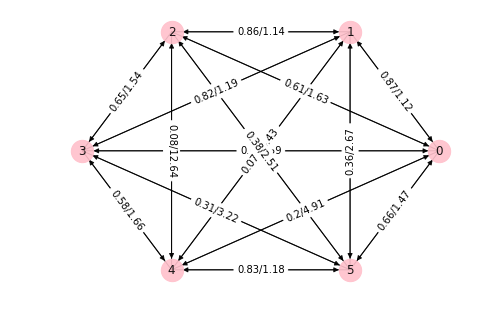

In [4]:
# display corresponding directed graph

An arbitrage is a cylce for which the **cumulative product** of the edge weights in an exchange rate graph is bigger than one. 

## Log-Transformed Representations

There are many well known graph algorithms that deal with cycle lengths - the **cumulative sum** of the edge weights. Fortunately, one can easily translate a cumulative product optimization problem into a convex cumulative sum optimzation problem by taking logs. To see this, note that 
\begin{align}
ln\left(a\times b \right) = ln\left(a\right) + ln\left(b\right)
\end{align}

while noting that
\begin{align}
ln\left(x\right) \quad \text{is a positive and monotonic transformation.}
\end{align}

If we multiply everything with -1, convex maximization becomes convex minimization... Let us transform the above exchange rate matrix and the corresponding graph by taking negative logs.


Taking negative logs...


target                                                         
                  0           1           2          3          4          5
source 0   -ln(1.0)   -ln(0.87)   -ln(0.61)   -ln(0.6)   -ln(0.2)  -ln(0.66)
       1  -ln(1.12)    -ln(1.0)   -ln(0.86)  -ln(0.82)  -ln(0.07)  -ln(0.36)
       2  -ln(1.63)   -ln(1.14)    -ln(1.0)  -ln(0.65)  -ln(0.08)  -ln(0.38)
       3  -ln(1.59)   -ln(1.19)   -ln(1.54)   -ln(1.0)  -ln(0.58)  -ln(0.31)
       4  -ln(4.91)  -ln(14.43)  -ln(12.64)  -ln(1.66)   -ln(1.0)  -ln(0.83)
       5  -ln(1.47)   -ln(2.67)   -ln(2.51)  -ln(3.22)  -ln(1.18)   -ln(1.0)



...results in:


target                                                  
                 0         1         2         3         4         5
source 0  0.000000  0.139262  0.494296  0.510826  1.609438  0.415515
       1 -0.113329  0.000000  0.150823  0.198451  2.659260  1.021651
       2 -0.488580 -0.131028  0.000000  0.430783  2.525729  0.967584
       3 -0.463734 -0.173953 -0.431782  0.000000  0.544727  1.171183
       4 -1.591274 -2.669309 -2.536866 -0.506818  0.000000  0.186330
       5 -0.385262 -0.982078 -0.920283 -1.169381 -0.165514  0.000000

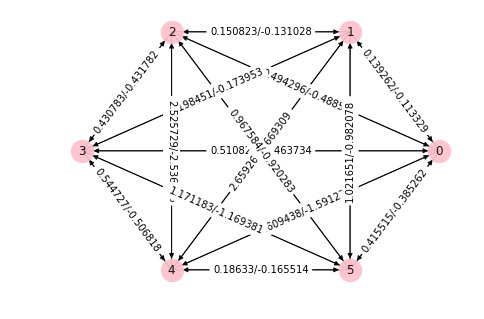

In [5]:
# display log-transformed exchange rate matrix and corresponding graph

Every cycle of **negative length** in the above graph with negative-log-transformed weights is an arbitrage cylce. 

# Identifying Arbitrage Cycles

## Finding an Arbitrage Cycle with Bellman-Ford

One can check if an arbitrage cylce exists and if so, **identify one such a cylce** in the log-transformed graph representation using a slighlty adjusted [Bellman-Ford algorithm](https://en.wikipedia.org/wiki/Bellman-Ford_algorithm) which has a complexity of $\mathcal{O}(|V||E|)$ where $|V|$ denotes the number of vertices and $|E|$ denotes the number of edges. A neat visualization of how the Bellman-Ford algorithm works can be found [here](https://www-m9.ma.tum.de/graph-algorithms/spp-bellman-ford/index_en.html). 

The Bellman-Ford algorithm itself only gives the shortest distance from a prespecified source node to all other nodes in the graph. It needs to be adjusted to:
- show if there is a negative cycle
- to output a negative cycle
- to always find a negative cycle (if there is one) even the graph is not connected

In [6]:
# The Bellman-Ford function used in this notebook
def bf_negative_cycle(G):

    # Remove nan edges
    n = len(G.nodes()) + 1
    edges = [edge for edge in G.edges().data() if ~np.isnan(edge[2]['weight'])]

    # Add a starting node and add edges with zero weight to all other nodes
    start_node_edges = [(n-1, i, {'weight': 0}) for i in range(n-1)]
    edges = edges + start_node_edges

    # Initialize node distances and predecessors
    d = np.ones(n) * np.inf
    d[n - 1] = 0  # Starting node has zero distance
    p = np.ones(n) * -1

    # Relax n times
    for i in range(n):  
        x = -1
        for e in edges:
            if d[int(e[0])] + e[2]['weight'] < d[int(e[1])]:
                d[int(e[1])] = d[int(e[0])] + e[2]['weight']
                p[int(e[1])] = int(e[0])
                x = int(e[1])
        if x == -1:  # If no relaxation possible, no negative cycle
            return None
        
    # Identify negative cycle
    for i in range(n):
        x = p[int(x)]
    cycle = []
    v = x
    while True:
        cycle.append(int(v))
        if v == x and len(cycle) > 1:
            break
        v = p[int(v)]
    return list(reversed(cycle))

At least one arbitrage cycle exists! One such cycle is [5, 3, 4, 5] with cycle length -0.4383 which implies and arbitrage multiplier of 1.5501.


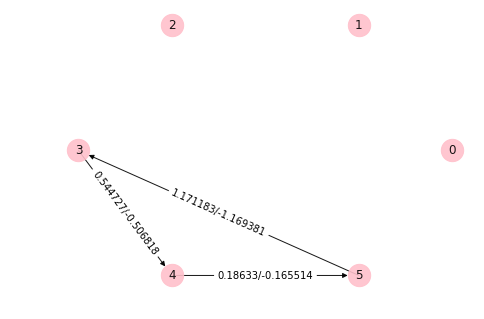

In [7]:
# Check if arbitrage cycle exists using Bellman-Ford. If so, output an arbitrage cycle

## Finding an "Optimal" Set of Cycles 

Identifying the cycle with an arbitrary number of vertices with the **largest** arbitrage multiplier is NP-hard in general. Finding this cycle with many tradable pairs thus quickly becomes computationally infeasible and one has to resort to approximate/heuristic algorithms.

Observe that finding the cycle with the largest multiplier (i.e. the cycle with the most negative cycle length in the graph with negative-log-transformed weights) of all cycles that visit each vertex exactly once is equivalent to the (asymmetric) [Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) - a well known NP-hard problem. The Travelling Salesman Problem (TSP) with $n+1$ cities can be formulated as an integer linear program for a edge weight matrix $C$ as follows
\begin{align}
\min &\sum_{i=0}^n \sum_{j\ne i,j=0}^nc_{ij}x_{ij} &&  \\
     & 0 \le x_{ij} \le 1  && i,j=0, \cdots, n  \\
     & u_{i} \in \mathbf{Z} && i=0, \cdots, n \\
     & \sum_{i=0,i\ne j}^n x_{ij} = 1 && j=0, \cdots, n \\
     & \sum_{j=0,j\ne i}^n x_{ij} = 1 && i=0, \cdots, n \\
&u_i-u_j +nx_{ij} \le n-1 && 1 \le i \ne j \le n
\end{align}



The TSP is only **NP-hard because we are asking for a single roundtrip solution** that covers all cities / currencies (the last two sets of constraints in the above formulation). But **subtours are fine in the arbitrage finding task** and even skipping some assets completely (a self-cylce) is not a problem! 

If we remove the "no-subtours" constaints of the TSP and also account for the diagonal of $X$ in the objective function, we arrive at the linear programming relaxation of the [assignment problem](https://en.wikipedia.org/wiki/Assignment_problem) 
\begin{align}
\min &\sum_{i=0}^n \sum_{j=0}^nc_{ij}x_{ij} &&  \\
     & 0 \le x_{ij} \le 1  && i,j=0, \cdots, n  \\
     & \sum_{i=0}^n x_{ij} = 1 && j=0, \cdots, n \\
     & \sum_{j=0}^n x_{ij} = 1 && i=0, \cdots, n \\
\end{align}
This linear program always has an integer solution (due to the totally unimodular linear constraint matrix) and thus solves the assignment problem. You can use a very specialized solver for the assignment problem (this notebook uses [this one](https://developers.google.com/optimization/assignment/simple_assignment)  - extremely fast and exact solutions!) or just solve the linear program above - [CVXPY](https://www.cvxpy.org/) makes this very easy. 

In [8]:
# Alternative: Solve Assignment Problem with CVXPY 
#X = Variable((len(C_ln),len(C_ln)))
#iota = np.ones((len(C_ln),1))
#
#constraints = [X <= 1,
#               X >= 0,
#               X*iota == 1,
#               np.transpose(iota)*X == 1]
#
## Form objective.
#obj = Minimize(sum(multiply(X, C_ln)))
#
## Form and solve problem.
#prob = Problem(obj, constraints)
#prob.solve()  # Returns the optimal value.
#print ("status:", prob.status)
#print ("optimal value", prob.value)
#X = pd.DataFrame(X.value)
#display(X)


 Optimal cycle set multiplier (assumes one has enough quantities in every sub-cycle): 25.395833971200002. 
 Multiplier is garuanteed to be at least as large as the multiplier found by Bellman-Ford (1.5501 in this example).


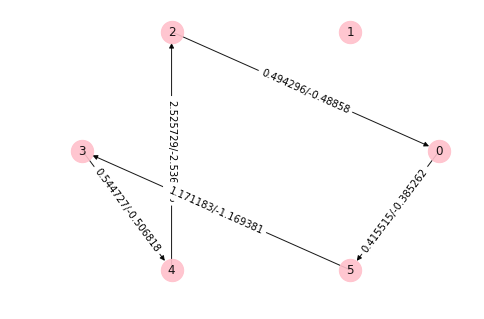

In [9]:
# Find best set of arbitrage cycles by solving the assignment problem

## Beyond Arbitrage Cycles - Maximize wrt. Quantities

Assume that we start out with one quantity in each currency. Let us find the set of trades that maximize the quantity in currency $k$ without changing the other quantities. For two matrices $A$ and $B$ of the same dimensions, let $A\circ B$ denote the element-wise product (also denoted [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))). 

Let $C$ denote the exchange rate matrix (not log-transformed) and $Q$ a matrix of the same size as $C$ where the entry $Q_{i,j}$ denotes the number of $i$ coins that flow from currency $i$ to currency $j$. Let $\mathbb{1}$ denote a vector of ones of size $N\times 1$, then vector of outflows from the respective currency inventories is

\begin{align}
\text{outflows} = Q \mathbb{1}.
\end{align}
The vector of inflows (also in currency $i$ units) is

\begin{align}
\text{inflows} = (Q \circ C)' \mathbb{1}
\end{align}
and hence the delta inventory is

\begin{align}
\Delta\! I = (Q \circ C)' \mathbb{1} - Q \mathbb{1}.
\end{align}

Let $I_{init}$ denote the initial inventory the maximizre 

\begin{align}
\max_{Q} \Delta\! I_k  &&  \\
     & \Delta\! I_{\neq k} =0 && \text{| No change in inventory in other assets}\\
     & \Delta\! I_k  \leq 1000 && \text{| Problem would be unbounded if arb-cycle exists}\\ \\
\end{align}

The nice thing about this setup is that it allows to easily incorperate new constraints like the blocksize of the observed quotes. The drawback is that this is numerically extremely challenging!

target                                
              0      1      2     3     4     5
source 0   1.00   0.87   0.61  0.60  0.20  0.66
       1   1.12   1.00   0.86  0.82  0.07  0.36
       2   1.63   1.14   1.00  0.65  0.08  0.38
       3   1.59   1.19   1.54  1.00  0.58  0.31
       4   4.91  14.43  12.64  1.66  1.00  0.83
       5   1.47   2.67   2.51  3.22  1.18  1.00

,inventory_start
currency,
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0


seconds it took: 0.014236211776733398
status:  optimal
optimal value:  1000.6383774259169

 Quantities matrix Q:


target                                              
                0         1        2        3        4        5
source 0        0   5.40016    6.202  4.46131  5.72456  100.599
       1  104.769         0  1.12855  68.0275   2.5868  83.0779
       2  164.245  0.230056        0  36.2159  2.64954  81.6778
       3  74.6763   2.28197  1.16464        0   93.572  2.99669
       4  125.539   16.9958  21.5959  3.02398        0  3.87521
       5   1.9288   2.49594  2.19044  27.2274   97.644        0

,inventory_start,inventory_delta,inventory_after_trades
currency,,,
0,1.0,1000.638377,1001.638377
1,1.0,-0.000548,0.999452
2,1.0,-0.000449,0.999551
3,1.0,-0.000029,0.999971
4,1.0,0.000080,1.000080
5,1.0,0.000024,1.000024


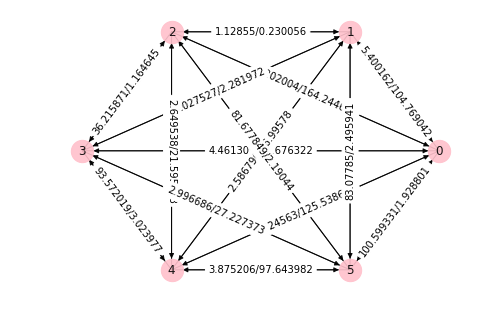

In [10]:
# Maximize inventory

# Live Arbitrage Identification

In this part, we are looking for live arbitrage opportunities on some centralized exchanges. The main tool we use for this is [CCXT](https://github.com/ccxt/ccxt) - an open source JavaScript / Python / PHP cryptocurrency trading library with support for more than 130 crypto exchanges.



The Binance fee structure can be found [here](https://www.binance.com/en/fee/schedule).

In [11]:
# set some parameters
pct_trading_fee = 0.0003
exchange = ccxt.binance()
markets = pd.DataFrame(exchange.load_markets())  # needs to run once after exchange is set

In [13]:
# create real time exchange rate matrix

Updating all quotes (432 pairs overall) took 0.22894692420959473 seconds.


,ADA,ADX,AE,AGI,AION,AMB,APPC,ARDR,ARK,ARN,...,XLM,XMR,XRP,XVG,XZC,YOYOW,ZEC,ZEN,ZIL,ZRX
ADA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARDR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Bellmann-Ford took 0.19998884201049805 seconds.
At least one arbitrage cycle exists! One such cycle is ['BTC', 'XZC', 'XRP', 'BTC'] with cycle length -0.001180762427733 which implies and arbitrage multiplier of 1.0011814598021394.


Node,0,1,2
Ticker,BTC,XZC,XRP


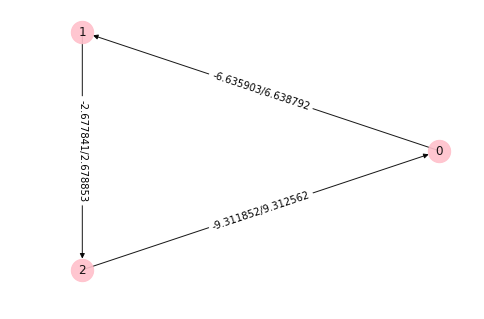

In [14]:
# Check if arbitrage cycle exists using Bellman-Ford. If so, output an arbitrage cycle

Solving assignment problem took 0.0515897274017334 seconds.

 Assignment problem multiplier is 1.0013602686271252.


Node,0,1,2,3,4
Ticker,BNB,BTC,ETH,NAV,TUSD


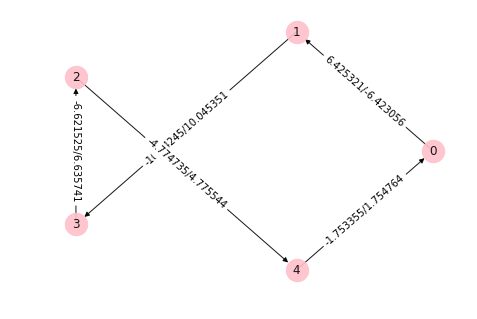

In [15]:
# Find best set of arbitrage cycles by solving the assignment problem  

# Practical Challenges of Arbitrage Trading

Aspects to consider:
* Availability of funds
* Cost of having funds
* Timing issues
* Available liqudity
* Precision of quantities
* Oder cancelations
* ...